In [1]:
# Jupyter cell: compute GFLOP/s for 4 runs of Horn–Schunck

import math

runs = [
    {"name": "run1_640x360",  "width": 640,  "height": 360,  "frames": 64, "iters": 20, "time": 0.0609608},
    {"name": "run2_1280x720", "width": 1280, "height": 720, "frames": 64, "iters": 20, "time": 0.0960524},
    {"name": "run3_1920x1080","width": 1920, "height": 1080,"frames": 64, "iters": 20, "time": 0.218126},
    {"name": "run4_2560x1440","width": 2560, "height": 1440,"frames": 64, "iters": 20, "time": 0.1667252},
    {"name": "run4_3840x2160","width": 3840, "height": 2160,"frames": 64, "iters": 20, "time": 0.298504},
]

flops_per_pixel_per_iter = 44.0  # from HS kernel analysis

for r in runs:
    w     = r["width"]
    h     = r["height"]
    n_f   = r["frames"]
    iters = r["iters"]
    t     = r["time"]

    if n_f < 2 or t <= 0:
        print(f"{r['name']}: invalid data, skipping")
        continue

    n_pairs  = n_f - 1
    pixels   = w * h

    total_flops  = n_pairs * pixels * iters * flops_per_pixel_per_iter
    total_gflops = total_flops / 1e9
    gflops_per_s = total_gflops / t

    print(f"{r['name']}:")
    print(f"  total work   = {total_gflops:8.3f} GFLOPs")
    print(f"  performance  = {gflops_per_s:8.2f} GFLOP/s\n")


run1_640x360:
  total work   =   12.773 GFLOPs
  performance  =   209.53 GFLOP/s

run2_1280x720:
  total work   =   51.094 GFLOPs
  performance  =   531.93 GFLOP/s

run3_1920x1080:
  total work   =  114.960 GFLOPs
  performance  =   527.04 GFLOP/s

run4_2560x1440:
  total work   =  204.374 GFLOPs
  performance  =  1225.81 GFLOP/s

run4_3840x2160:
  total work   =  459.842 GFLOPs
  performance  =  1540.49 GFLOP/s



AMD GPU specs: 

- **Peak FP32 Performance:** 163.4 TFLOP/s = **163,400 GFLOP/s**
- **Peak Memory Bandwidth:** 5.3 TB/s = **5,300 GB/s**

**Ridge Point:** 
$$\frac{163,400 \text{ GFLOP/s}}{5,300 \text{ GB/s}} = 30.83 \text{ FLOP/byte}$$

**HS kernel: AI = $1.32$ FLOP/byte**

Since $1.32 < 30.83$, the kernel is **memory-bound**.

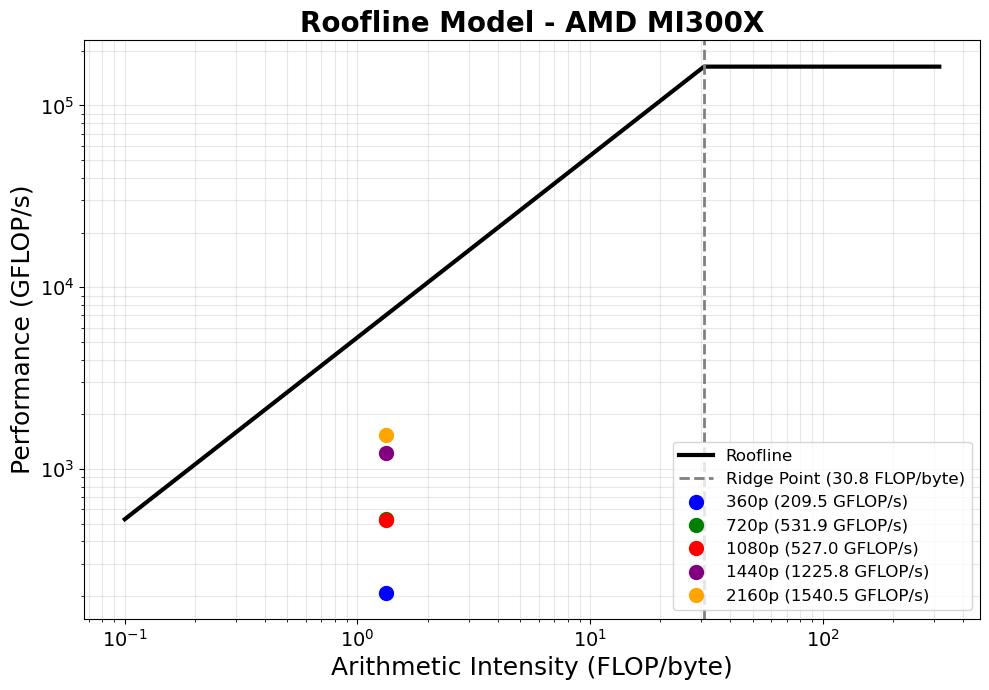

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# GPU specs
peak_compute = 163400  # GFLOP/s
peak_bandwidth = 5300  # GB/s
ridge_point = peak_compute / peak_bandwidth

# Generate roofline
ai = np.logspace(-1, 2.5, 500)
bandwidth_bound = peak_bandwidth * ai
compute_bound = np.full_like(ai, peak_compute)
roofline = np.minimum(bandwidth_bound, compute_bound)

# Actual measured performance
hs_ai = 1.32  # FLOP/byte

# Multi-resolution measurements
resolutions = ['360p', '720p', '1080p', '1440p', '2160p']
gflops_values = [209.53, 531.93, 527.04, 1225.81, 1540.49]
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot
plt.figure(figsize=(10, 7))
plt.loglog(ai, roofline, 'k-', linewidth=3, label='Roofline')
plt.axvline(ridge_point, color='gray', linestyle='--', linewidth=2, 
            label=f'Ridge Point ({ridge_point:.1f} FLOP/byte)')

# Plot multi-resolution points
for res, gflops, color in zip(resolutions, gflops_values, colors):
    plt.plot(hs_ai, gflops, 'o', color=color, markersize=10, 
             label=f'{res} ({gflops:.1f} GFLOP/s)', zorder=5)

plt.xlabel('Arithmetic Intensity (FLOP/byte)', fontsize=18)
plt.ylabel('Performance (GFLOP/s)', fontsize=18)
plt.title('Roofline Model - AMD MI300X', fontsize=20, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, which='both', alpha=0.3)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('roofline.png', dpi=300)
plt.show()